## Reading and Aggregating Raw Data

In [1]:
# Reads in data, drops duplicate rows, and joins data, creating and filling columns for each score and num_comments interval
import pandas as pd
import numpy as np

# Set input filenames
stream_fname = 'stream_AskReddit+Pics+Gifs+Videos+WorldNews+Funny+Aww+gaming_2018-11-30_003448.csv'
score_fname = 'score_AskReddit+Pics+Gifs+Videos+WorldNews+Funny+Aww+gaming_2018-11-30_003448.csv'

# Read csv files into dataframes, drop duplicate rows from each
data_raw = pd.read_csv(stream_fname, index_col='id')
data_raw = data_raw[~data_raw.index.duplicated(keep='first')]
scores = pd.read_csv(score_fname)
scores = scores[~scores[['id','minutes']].duplicated(keep='first')]
scores.set_index(keys='id', inplace=True)

# Intervals for sample data 
mins_list = [5, 10, 15, 30, 60] + [120 + 60 * k for k in range(23)]

# Join data, creating columns for fields that we need to track over time
for mins in mins_list:
    data_raw = data_raw.join(scores[scores.minutes == mins][['score', 'num_comments','num_crossposts','gilded']], 
                             rsuffix = '_%d' % mins)
    

## Data Cleaning and Creating Target Variable

In [35]:
# Set data to copy of data_raw so we don't have to re-read from file every time we want to change threshold
data = data_raw.copy()

# Set thresholds for target variable and predict-by time
target_score = 3656
predict_by = 5

# Create target variable column based on condition (data[score_predict_by] >= target_score)
data['Y'] = data['score_1440'].apply(lambda x: 1 if x >= target_score else 0)

# Drop rows with NaN values 
data.dropna(inplace=True)

# Drop columns we don't need 
data.drop(columns=['time_retrieved_utc', 'score', 'subreddit_id', 'minutes', 'permalink', 
                   '_comments_by_id', 'author', 'num_comments', 'num_crossposts'], inplace=True)


# Drop '_mins' columns after predict-by time
data.drop(columns=['score_'+str(mins) for mins in mins_list if mins > predict_by], inplace=True)
data.drop(columns=['num_comments_'+str(mins) for mins in mins_list if mins > predict_by], inplace=True)
data.drop(columns=['num_crossposts_'+str(mins) for mins in mins_list if mins > predict_by], inplace=True)
data.drop(columns=['gilded_'+str(mins) for mins in mins_list if mins > predict_by], inplace=True) 

$$\textbf{Now dataframe is well-cleaned!}$$

## Feature Engineering

In [36]:
from datetime import datetime
import tldextract

# Add columns for differences between each interval of scores, num_comments, num_crossposts, and gilded
# !!! also try rates instead of differences 
for col in ['score_','num_comments_','num_crossposts_','gilded_']:
    for idx, mins in enumerate(mins_list):
        if mins < predict_by:
            data[col+'diff_'+str(mins_list[idx])+'_'+str(mins_list[idx+1])] = data[col+str(mins_list[idx+1])] \
                                                                                -data[col+str(mins_list[idx])]   
    
# Reset index to default
data.reset_index(drop=True, inplace=True)

# Title engineering/NLP -- (!!! dropping all text for now, until we do text/NLP)
data['title_len'] = data['title'].apply(len)
data.drop(columns=['title'], inplace=True)

# Text processing/NLP

# Converting created_utc to day_of_week and hour_of_day and adding these columns, then drop created-utc
def utc_to_day(utc):
    return datetime.fromtimestamp(utc).strftime('%A') 

def utc_to_hour(utc):
    return datetime.fromtimestamp(utc).strftime('%H')

data['day'] = data['created_utc'].apply(utc_to_day)
data['hour'] = data['created_utc'].apply(utc_to_hour)
data.drop(columns=['created_utc'], inplace=True)

# Extract domain from url's and add as column 
def domain_extract(url):
    return tldextract.extract(url).domain

#data['domain'] = data['url'].apply(domain_extract)
data.drop(columns=['url'], inplace=True)

# Create dummy variables for all categorical data
#data = pd.get_dummies(data, columns=['subreddit','day','hour','domain'])
data = pd.get_dummies(data, columns=['subreddit','day','hour'])

# Convert boolean variables to 1's and 0's
data = data * 1

## Train/Test Split

In [45]:
from sklearn.model_selection import train_test_split

test_size = 0.2
random_state = int(np.random.rand() * (2 ** 32 - 1)) # use a new random state everytime as we run the cell

# Split train and test data
X_train, X_test, Y_train, Y_test = train_test_split(data.drop(columns=['Y']), data['Y'], test_size=test_size, 
                                                    stratify = data['Y'], random_state=random_state)


## Downsampling Majority Class

In [46]:
majority_count = Y_train.value_counts()[0]
minority_count = Y_train.value_counts()[1]
print('majority_count: '+str(majority_count))
print('minority_count: '+str(minority_count))

majority_count: 41340
minority_count: 595


In [99]:
from sklearn.utils import resample

# Keep copy of non-downsampled data to try other techniques with
train_data = pd.concat([X_train,Y_train], axis = 1)
train_data_ds = train_data.copy()

# Separate majority and minority classes
train_data_ds_majority = train_data_ds[train_data_ds.Y == 0]
train_data_ds_minority = train_data_ds[train_data_ds.Y == 1]

# Downsample majority class
train_majority_downsampled = resample(train_data_ds_majority, 
                                 replace = False,    # sample without replacement
                                 n_samples = minority_count,     # to match minority class
                                 random_state = int(np.random.rand() * (2 ** 32 - 1))) # reproducible results
 
# Combine minority class with downsampled majority class
train_data_ds = pd.concat([train_majority_downsampled, train_data_ds_minority])

# Split downsampled data into X_train_ds and Y_train_ds
Y_train_ds = train_data_ds['Y']
X_train_ds = train_data_ds.drop(columns=['Y'])

# Display new class counts
majority_count_ds = Y_train_ds.value_counts()[0]
minority_count_ds = Y_train_ds.value_counts()[1]
print('majority_count: '+str(majority_count_ds))
print('minority_count: '+str(minority_count_ds))
print(len(train_data.index))

majority_count: 595
minority_count: 595
41935


## Standardize Data

In [48]:
from sklearn import preprocessing

# Make copy of test data for using with downsampled training data
X_test_ds = X_test.copy()


# !!! Remember to store the dataframe after transformation (just writing the transformer will not store the dataframe)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(data = scaler.transform(X_train), columns = X_train.columns, index = X_train.index)
X_test_scaled = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns, index = X_test.index) 
# !!! Here we use the statistic of training set to scale the entire data. This also prevents data leakage

# Separate standarization for downsampled data--
scaler_ds = preprocessing.StandardScaler().fit(X_train_ds)
X_train_ds_scaled = pd.DataFrame(data = scaler.transform(X_train_ds), columns = X_train_ds.columns, index = X_train_ds.index)

# Standardize test data for downsampling case (!!! should this be done? Or scale based on unsampled data?)
X_test_ds_scaled = pd.DataFrame(data = scaler.transform(X_test_ds), columns = X_test_ds.columns, index = X_test_ds.index)

In [101]:
print('X_train_scaled ',X_train_scaled.shape)
print('Y_train ',Y_train.shape)
print('X_test_scaled ',X_test_scaled.shape)
print('Y_test ',Y_test.shape)
print('X_train_ds_scaled ',X_train_ds_scaled.shape)
print('Y_train_ds ',Y_train_ds.shape)
print('X_test_ds_scaled ',X_test_ds_scaled.shape)
print('Y_test_ds', Y_test.shape)

X_train_scaled  (41935, 50)
Y_train  (41935,)
X_test_scaled  (10484, 50)
Y_test  (10484,)
X_train_ds_scaled  (1190, 50)
Y_train_ds  (1190,)
X_test_ds_scaled  (10484, 50)
Y_test_ds (10484,)


## Models With Class Balancing Techniques Compared

Text(0.5,0,'False Positive Rate')

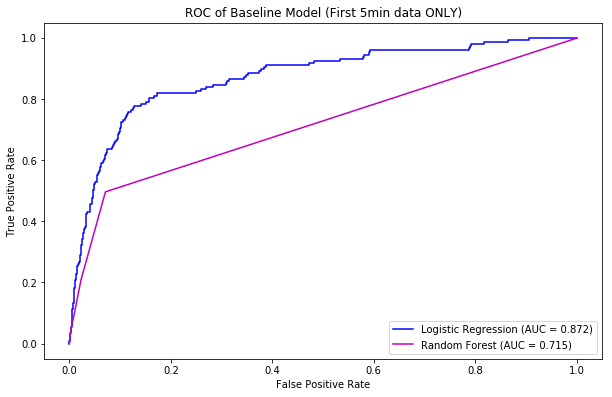

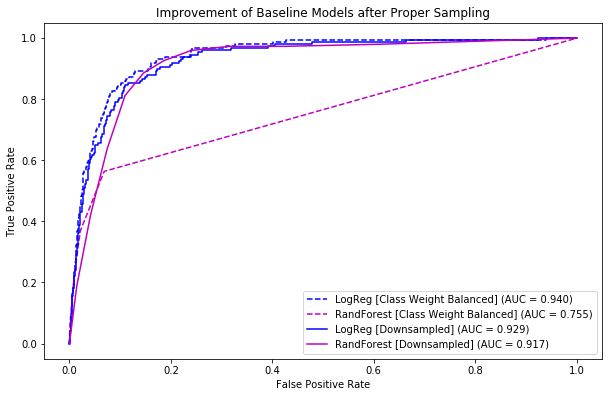

In [237]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline


####The very, very, very naive baseline
# First to subsample the training set so that it has size same as downsampled set
idx_baby = np.random.randint(0, len(Y_train), len(Y_train_ds))
X_train_baby, Y_train_baby = X_train_scaled.iloc[idx_baby], Y_train.iloc[idx_baby]

lr_baby = LogisticRegression()
lr_baby.fit(X_train_baby, Y_train_baby)
preds_lr_baby = lr_baby.predict_proba(X_test_scaled)[:, 1]
fpr_lr_baby, tpr_lr_baby, threshoulds_lr_baby = roc_curve(Y_test, preds_lr_baby)
roc_auc_lr_baby = auc(fpr_lr_baby, tpr_lr_baby)

rf_baby = RandomForestClassifier()
rf_baby.fit(X_train_baby, Y_train_baby)
preds_rf_baby = rf_baby.predict_proba(X_test_scaled)[:, 1]
fpr_rf_baby, tpr_rf_baby, threshoulds_rf_baby = roc_curve(Y_test, preds_rf_baby)
roc_auc_rf_baby = auc(fpr_rf_baby, tpr_rf_baby)

plt.figure(figsize = (10, 10*0.618))
plt.title('ROC of Baseline Model (First '+str(predict_by)+'min data ONLY)')
plt.plot(fpr_lr_baby, tpr_lr_baby, 'b',label = 'Logistic Regression' + ' (AUC = %0.3f)' % roc_auc_lr_baby)
plt.plot(fpr_rf_baby, tpr_rf_baby, 'm',label = 'Random Forest' + ' (AUC = %0.3f)' % roc_auc_rf_baby)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

##############################################################################
# Logistic Regression Class Balanced
lr_baseline = LogisticRegression(class_weight='balanced')
lr_baseline.fit(X_train_scaled, Y_train)
preds_lr_baseline = lr_baseline.predict_proba(X_test_scaled)[:, 1]
fpr_lr_baseline, tpr_lr_baseline, thresholds_lr_baseline = roc_curve(Y_test, preds_lr_baseline)
roc_auc_lr_baseline = auc(fpr_lr_baseline, tpr_lr_baseline)

# Random Forest Class Balanced
rf_baseline = RandomForestClassifier(class_weight='balanced')
rf_baseline.fit(X_train_scaled, Y_train)
preds_rf_baseline = rf_baseline.predict_proba(X_test_scaled)[:, 1]
fpr_rf_baseline, tpr_rf_baseline, thresholds_rf_baseline = roc_curve(Y_test, preds_rf_baseline)
roc_auc_rf_baseline = auc(fpr_rf_baseline, tpr_rf_baseline)

# Logistic Regression Downsampled
lr_baseline_ds = LogisticRegression()
lr_baseline_ds.fit(X_train_ds_scaled, Y_train_ds)
preds_lr_baseline_ds = lr_baseline_ds.predict_proba(X_test_ds_scaled)[:, 1]
fpr_lr_baseline_ds, tpr_lr_baseline_ds, thresholds_lr_baseline_ds = roc_curve(Y_test, preds_lr_baseline_ds)
roc_auc_lr_baseline_ds = auc(fpr_lr_baseline_ds, tpr_lr_baseline_ds)

# Random Forest Downsampled
rf_baseline_ds = RandomForestClassifier()
rf_baseline_ds.fit(X_train_ds_scaled, Y_train_ds)
preds_rf_baseline_ds = rf_baseline_ds.predict_proba(X_test_ds_scaled)[:, 1]
fpr_rf_baseline_ds, tpr_rf_baseline_ds, thresholds_rf_baseline_ds = roc_curve(Y_test, preds_rf_baseline_ds)
roc_auc_rf_baseline_ds = auc(fpr_rf_baseline_ds, tpr_rf_baseline_ds)

# Plot the ROC curves
plt.figure(figsize = (10, 10*0.618))
plt.title('Improvement of Baseline Models after Proper Sampling')
plt.plot(fpr_lr_baseline, tpr_lr_baseline, 'b--', label = 'LogReg [Class Weight Balanced]' + ' (AUC = %0.3f)' % roc_auc_lr_baseline)
plt.plot(fpr_rf_baseline, tpr_rf_baseline, 'm--',label = 'RandForest [Class Weight Balanced]' + ' (AUC = %0.3f)' % roc_auc_rf_baseline)
plt.plot(fpr_lr_baseline_ds, tpr_lr_baseline_ds, 'b',label = 'LogReg [Downsampled]' + ' (AUC = %0.3f)' % roc_auc_lr_baseline_ds)
plt.plot(fpr_rf_baseline_ds, tpr_rf_baseline_ds, 'm',label = 'RandForest [Downsampled]' + ' (AUC = %0.3f)' % roc_auc_rf_baseline_ds)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## Lime

In [33]:
'''import numpy as np
from lime import lime_tabular
explainer = lime_tabular.LimeTabularExplainer(X_train_ds.values, feature_names=X_train_ds.columns.values, class_names=['Not Viral', 'Is Viral'], \
                                                   discretize_continuous=True)
i = np.random.randint(0, X_test.shape[0])
exp = explainer.explain_instance(X_test.values[i], rf_baseline_ds.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True, show_all=False)'''

"import numpy as np\nfrom lime import lime_tabular\nexplainer = lime_tabular.LimeTabularExplainer(X_train_ds.values, feature_names=X_train_ds.columns.values, class_names=['Not Viral', 'Is Viral'],                                                    discretize_continuous=True)\ni = np.random.randint(0, X_test.shape[0])\nexp = explainer.explain_instance(X_test.values[i], rf_baseline_ds.predict_proba, num_features=10)\nexp.show_in_notebook(show_table=True, show_all=False)"

In [34]:
'''exp.as_pyplot_figure()'''

'exp.as_pyplot_figure()'

# Hyperparameter Tuning for Logistic Regression

In [51]:
# Before doing anything, aggregate X_train_ds_scaled and Y_train_ds together
train_ds_scaled = pd.concat([X_train_ds_scaled, Y_train_ds], axis = 1)

$\text{Define function for AUC vs hyperparameter C.}$

In [126]:
from sklearn.model_selection import KFold
from tqdm import tqdm

# Below is a function that run k-fold cross-validation of Logistic regression on an array of C's.
def HyperParamLR(dataset, cs, p, k): # 'dataset' variable here should be X_train before scaling
    # Construct a matrix that records the values of AUC
    auc_temp = np.zeros((len(cs), k))
    
    # Cross-validation is split within the original train dataset
    kf = KFold(n_splits = k, shuffle = True) # shuffle must be True
    splits = list(kf.split(dataset)) 
    
    for i in range(len(splits)):
        train_index, val_index = splits[i]
        cv_train = dataset.iloc[train_index, :]
        cv_validate = dataset.iloc[val_index, :]
        
        X_Train, X_Val = cv_train.drop(['Y'], axis = 1), cv_validate.drop(['Y'], axis = 1)
        Y_Train, Y_Val = cv_train['Y'], cv_validate['Y']
        
        # Scale the features based on the training set splitted out
        scaler = preprocessing.StandardScaler().fit(X_Train) # Scale based on training to prevent data leakage to validation set
        X_Train_scaled = pd.DataFrame(data = scaler.transform(X_Train), columns = X_Train.columns, index = X_Train.index)
        X_Val_scaled = pd.DataFrame(data = scaler.transform(X_Val), columns = X_Val.columns, index = X_Val.index) 
        
        # Training on each fold
        for c in cs:
            j = cs.index(c)
            lr = LogisticRegression(penalty = p, C = c)
            lr.fit(X_Train_scaled, Y_Train)
            preds = lr.predict_proba(X_Val_scaled)[:, 1]
            fpr, tpr, thresholds = roc_curve(Y_Val, preds)
            auc_temp[j, i] = auc(fpr, tpr)
            
    # Build the dictionary
    aucs = {}
    for l in range(len(cs)):
        aucs.update({cs[l]: auc_temp[l, :]})
    
    auc_results = [aucs.get(k) for k in cs]
    
    return auc_results

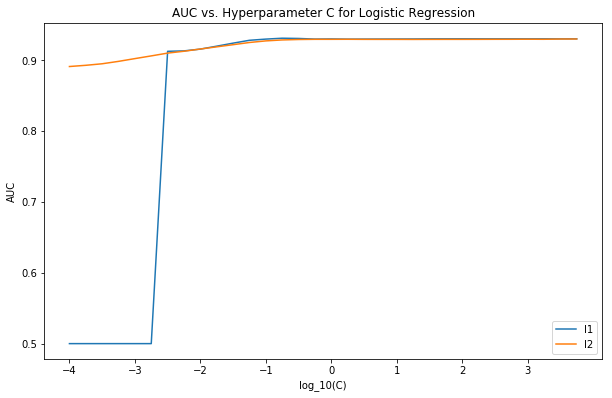

In [315]:
# Set the hyperparameter grid
cs_lr = [10**(i/4) for i in range(-16, 16)]

# 10-Fold cross-validation on downsampled set (NOTE: if we want to try class weight, then we need to revise the function)
lr_l1 = np.mean(HyperParamLR(train_ds_scaled, cs_lr, 'l1', 10), axis = 1)
lr_l2 = np.mean(HyperParamLR(train_ds_scaled, cs_lr, 'l2', 10), axis = 1)
plt.figure(figsize = (10, 10*0.618))
plt.plot(np.log10(cs_lr), lr_l1, label = 'l1')
plt.plot(np.log10(cs_lr), lr_l2, label = 'l2')
plt.title('AUC vs. Hyperparameter C for Logistic Regression')
plt.legend(loc = 'lower right')
plt.xlabel('log_10(C)')
plt.ylabel('AUC')
plt.xticks(np.arange(-4, 4))
plt.show()

$\text{Check for overfitting.}$

In [302]:
# Plot n randomly-chosen ROC of the k folds (Hyperparameter chosen by the best AUC)
def PlotROCs(dataset, c, p, k, n): # 'dataset' variable here should be X_train before scaling
    # Construct a figure
    plt.figure(figsize = (10, 10*0.618))
    plt.title('ROC of Randomly Chosen ' + str(n) + ' Folds for Logistic Regression'.format(p))

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    # Cross-validation is split within the original train dataset
    kf = KFold(n_splits = k, shuffle = True) # shuffle must be True
    splits = list(kf.split(dataset)) 
    
    for i in np.random.choice(k, size = n, replace = False):
        train_index, val_index = splits[i]
        cv_train = dataset.iloc[train_index, :]
        cv_validate = dataset.iloc[val_index, :]
        
        X_Train, X_Val = cv_train.drop(['Y'], axis = 1), cv_validate.drop(['Y'], axis = 1)
        Y_Train, Y_Val = cv_train['Y'], cv_validate['Y']
        
        # Scale the features based on the training set splitted out
        scaler = preprocessing.StandardScaler().fit(X_Train) # Scale based on training to prevent data leakage to validation set
        X_Train_scaled = pd.DataFrame(data = scaler.transform(X_Train), columns = X_Train.columns, index = X_Train.index)
        X_Val_scaled = pd.DataFrame(data = scaler.transform(X_Val), columns = X_Val.columns, index = X_Val.index) 
        
        # Train and plot on each selected fold
        lr = LogisticRegression(penalty = p, C = c)
        lr.fit(X_Train_scaled, Y_Train)
        preds = lr.predict_proba(X_Val_scaled)[:, 1]
        fpr, tpr, thresholds = roc_curve(Y_Val, preds)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = 'Fold {}'.format(i) + ' (AUC = %0.3f)' % roc_auc)
        plt.legend(loc = 'lower right')

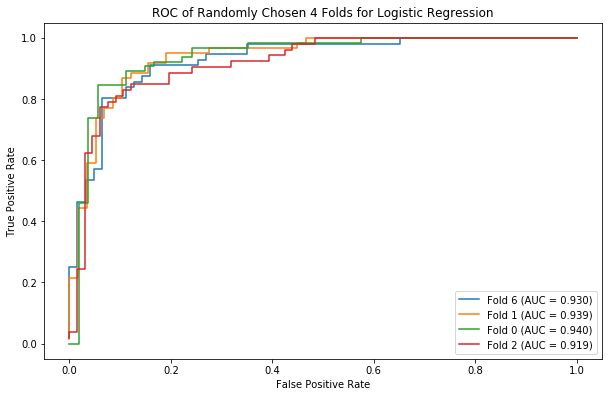

In [307]:
PlotROCs(train_data_ds, 10**(-0.5), 'l1', 10, 4)
# If the curves overlap, then overfitting does not occur within the training and validation set

$\text{Use the best hyperparameter to run LogReg and compare with baseline.}$

Text(0.5,0,'False Positive Rate')

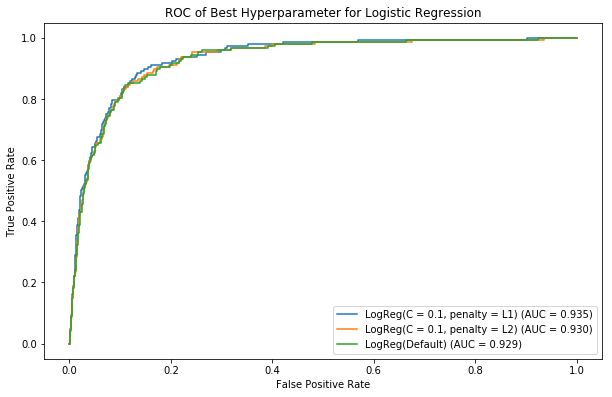

In [216]:
# Run on the best hyper-parameters
lr_best_l1 = LogisticRegression(C = 0.1, penalty = 'l1')
lr_best_l1.fit(X_train_ds_scaled, Y_train_ds)
preds_lr_best_l1 = lr_best_l1.predict_proba(X_test_scaled)[:, 1]
fpr_lr_best_l1, tpr_lr_best_l1, thresholds_lr_best_l1 = roc_curve(Y_test, preds_lr_best_l1)
roc_auc_lr_best_l1 = auc(fpr_lr_best_l1, tpr_lr_best_l1)

lr_best_l2 = LogisticRegression(C = 0.1, penalty = 'l2')
lr_best_l2.fit(X_train_ds_scaled, Y_train_ds)
preds_lr_best_l2 = lr_best_l2.predict_proba(X_test_scaled)[:, 1]
fpr_lr_best_l2, tpr_lr_best_l2, thresholds_lr_best_l2 = roc_curve(Y_test, preds_lr_best_l2)
roc_auc_lr_best_l2 = auc(fpr_lr_best_l2, tpr_lr_best_l2)


plt.figure(figsize = (10, 10*0.618))
plt.title('ROC of Best Hyperparameter for Logistic Regression')
plt.plot(fpr_lr_best_l1, tpr_lr_best_l1, label = 'LogReg(C = 0.1, penalty = L1)' + ' (AUC = %0.3f)' % roc_auc_lr_best_l1)
plt.plot(fpr_lr_best_l2, tpr_lr_best_l2, label = 'LogReg(C = 0.1, penalty = L2)' + ' (AUC = %0.3f)' % roc_auc_lr_best_l2)
plt.plot(fpr_lr_baseline_ds, tpr_lr_baseline_ds, label = 'LogReg(Default)' + ' (AUC = %0.3f)' % roc_auc_lr_baseline_ds)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Hyerparameter Tuning for Random Forest

$\text{Define function to find AUC given hyperparameter min_samples_split and min_samples_leaf.}$

In [170]:
# Hyperparameter tuning for Random Forest
def HyperParamRF(dataset, min_split, min_leaf, k):
    # Construct a matrix that records the values of AUC
    auc_temp = np.zeros((len(min_split), k))
    
    # Cross-validation is split within the original train dataset
    kf = KFold(n_splits = k, shuffle = True) # shuffle must be True
    splits = list(kf.split(dataset)) 
    
    for i in range(len(splits)):
        train_index, val_index = splits[i]
        cv_train = dataset.iloc[train_index, :]
        cv_validate = dataset.iloc[val_index, :]
        
        X_Train, X_Val = cv_train.drop(['Y'], axis = 1), cv_validate.drop(['Y'], axis = 1)
        Y_Train, Y_Val = cv_train['Y'], cv_validate['Y']
        
        # Scale the features based on the training set splitted out
        scaler = preprocessing.StandardScaler().fit(X_Train) # Scale based on training to prevent data leakage to validation set
        X_Train_scaled = pd.DataFrame(data = scaler.transform(X_Train), columns = X_Train.columns, index = X_Train.index)
        X_Val_scaled = pd.DataFrame(data = scaler.transform(X_Val), columns = X_Val.columns, index = X_Val.index) 
        
        for split in min_split:
            j = min_split.index(split)
            rf = RandomForestClassifier(min_samples_split = split, min_samples_leaf = min_leaf)
            rf.fit(X_Train_scaled, Y_Train)
            preds = rf.predict_proba(X_Val_scaled)[:, 1]
            fpr, tpr, thresholds = roc_curve(Y_Val, preds)
            auc_temp[j, i] = auc(fpr, tpr)
            
    # Build the dictionary
    aucs = {}
    for l in range(len(min_split)):
        aucs.update({min_split[l]: auc_temp[l, :]})
    auc_results = [aucs.get(k) for k in min_split]
    
    return auc_results

In [187]:
# Set the hyperparameter grid
min_samples_split = [2**(i/4)  for i in range(-60, -8)]
min_samples_leaf = [2**(i/1)  for i in range(-15, -2)]

# Record the mean AUC for each split and leaf
aucs = np.zeros((len(min_samples_leaf), len(min_samples_split)))
for leaf in min_samples_leaf:
    aucs[min_samples_leaf.index(leaf), :] = np.mean(HyperParamRF(train_ds_scaled, min_samples_split, leaf, 4), axis = 1)
    


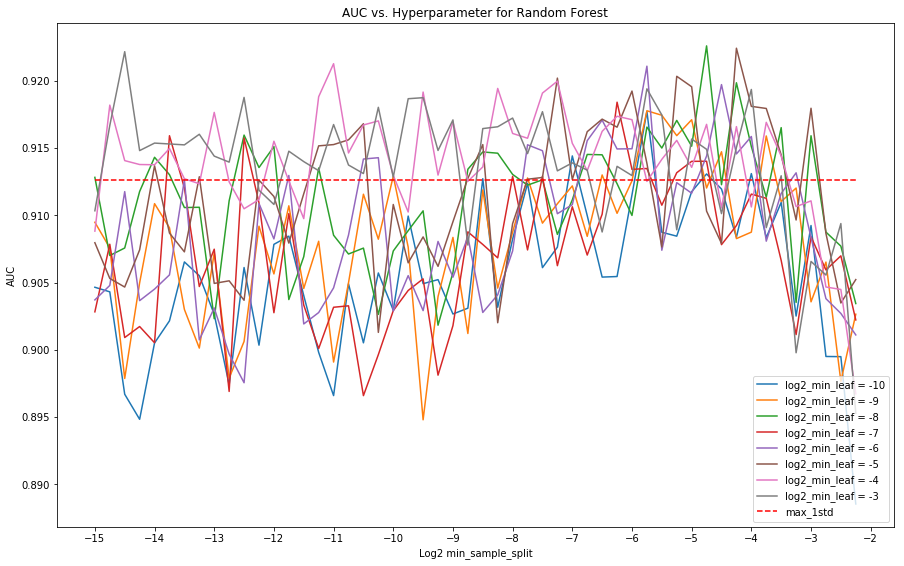

In [188]:
# max-1st-dev rule
auc_mean = np.mean(aucs, axis = 1)
auc_var = np.var(aucs, axis = 1)
auc_StdErr = np.sqrt(auc_var/10)
ii = np.where(auc_mean == np.max(auc_mean))
max_1std_val = auc_mean[ii] - auc_StdErr[ii]
max_1std = np.ones(len(min_samples_split))*max_1std_val

# Plot AUC vs hyperparameter
plt.figure(figsize = (15, 15*0.618))
for i in range(-10, -2):
    plt.plot(np.log2(min_samples_split), aucs[i+10, :], label = 'log2_min_leaf = {}'.format(i))
plt.plot(np.log2(min_samples_split), max_1std, 'r--', label = 'max_1std')
plt.title('AUC vs. Hyperparameter for Random Forest')
plt.legend(loc = 'lower right')
plt.xlabel('Log2 min_sample_split')
plt.ylabel('AUC')
plt.xticks(np.arange(-15, -1))
plt.show()

$\text{Choose the simplist model above the max-1std line: split = 10**(-5), leaf = 10**(-3)}$

$\text{Do feature importance on cross-validations.}$

In [154]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Apply feature importance into Random Forest(Best Hyperparameter Config)

def FeatureSelectRF(dataset, min_split, min_leaf, k, n):
    # Construct the plot
    fig, axes = plt.subplots(1, 4, figsize=(15, 15*0.5), sharey = True, sharex = True)
    plt.xticks([])
    plt.yticks([])
    
    # Randomly choose 4 folds (indexes) for plotting feature importance
    plot_true = np.random.choice(k, 4, replace = False)
    
    # Cross-validation is split within the original train dataset
    kf = KFold(n_splits = k, shuffle = True) # shuffle must be True
    splits = list(kf.split(dataset)) 
    
    for i in range(len(splits)):
        train_index, val_index = splits[i]
        cv_train = dataset.iloc[train_index, :]
        cv_validate = dataset.iloc[val_index, :]
        
        X_Train, X_Val = cv_train.drop(['Y'], axis = 1), cv_validate.drop(['Y'], axis = 1)
        Y_Train, Y_Val = cv_train['Y'], cv_validate['Y']
        
        # Scale the features based on the training set splitted out
        scaler = preprocessing.StandardScaler().fit(X_Train) # Scale based on training to prevent data leakage to validation set
        X_Train_scaled = pd.DataFrame(data = scaler.transform(X_Train), columns = X_Train.columns, index = X_Train.index)
        X_Val_scaled = pd.DataFrame(data = scaler.transform(X_Val), columns = X_Val.columns, index = X_Val.index) 
        
        # Train and plot on each selected fold (for finding 20 important features)
        rf = RandomForestClassifier(min_samples_split = min_split, min_samples_leaf = min_leaf)
        rf.fit(X_Train_scaled, Y_Train)
        
        feature_mi_rf = rf.feature_importances_
        feature_mi_rf_dict = dict(zip(X_Train.columns, feature_mi_rf))
        mi_rf = pd.DataFrame(data = list(feature_mi_rf_dict.items()), columns = ['Feature', 'Importance'])
        mi_rf_sorted = mi_rf.sort_values(by = ['Importance'], ascending = False)
        feature_selected = mi_rf_sorted['Feature'][0 : n]
        
        # Use the n important features on X_Train_scaled
        X_Train_f, X_Val_f = X_Train_scaled.filter(items = feature_selected), X_Val_scaled.filter(items = feature_selected)
        rf.fit(X_Train_f, Y_Train)
        preds = rf.predict_proba(X_Val_f)[:, 1]
        fpr, tpr, thresholds = roc_curve(Y_Val, preds)
        roc_auc = auc(fpr, tpr)
        
        #!!! Remember to build a matrix that records the ROC curve for each fold and then take average to plot generalized ROC

        if i in plot_true:
            position = plot_true.tolist().index(i) + 1
            ax = fig.add_subplot(1, 4, position)
            ax = sns.barplot(x = mi_rf_sorted['Feature'][0:10], y = mi_rf_sorted['Importance'][0:10], palette="GnBu_d")
            ax.set_title('Feature Importance of Fold {}'.format(i+1), fontsize = 10)
            ax.set_xlabel('Feature')
            ax.set_yticklabels([0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40], fontsize = 10)
            ax.set_xticklabels(ax.get_xticklabels(), fontsize = 10, rotation = 90)
            ax.tick_params(axis='x',which='both',bottom='off')

            

/Users/elle0804/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/elle0804/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/elle0804/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/elle0804/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Pas

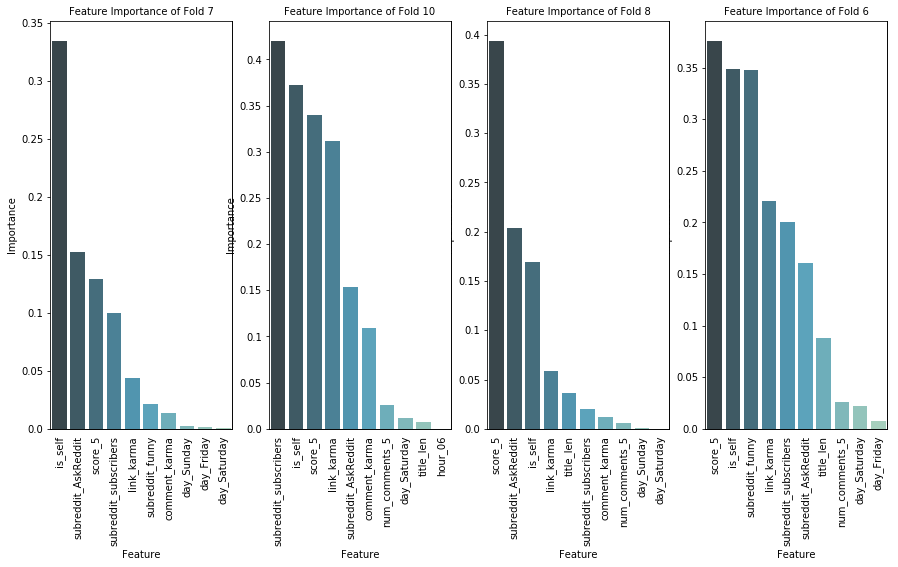

In [316]:
FeatureSelectRF(train_ds_scaled, 2**(-5), 2**(-3), 10, 10)

$\text{Question: How many features to use?}$

In [83]:
# Plot AUC vs feature number n (best hyperparam config, on k-fold validation)
def AUCvsFN (dataset, min_split, min_leaf, k, N, epoch):
    # Construct the plot
    fig, ([ax1, ax2]) = plt.subplots(1, 2, figsize=(15, 15*0.5))
    #plt.xticks([])
    #plt.yticks([])
    aucs_sum = np.zeros(len(N))
    for e in range(epoch):
        # Initialize an array recording average AUC for each n in N, the feature number array
        aucs = []
    
        # Cross-validation is split within the original train dataset
        kf = KFold(n_splits = k, shuffle = True) # shuffle must be True
        splits = list(kf.split(dataset)) 
    
        train_index, val_index = splits[0]
        cv_train = dataset.iloc[train_index, :]
        cv_validate = dataset.iloc[val_index, :]
        
        X_Train, X_Val = cv_train.drop(['Y'], axis = 1), cv_validate.drop(['Y'], axis = 1)
        Y_Train, Y_Val = cv_train['Y'], cv_validate['Y']
        
        # Scale the features based on the training set splitted out
        scaler = preprocessing.StandardScaler().fit(X_Train) # Scale based on training to prevent data leakage to validation set
        X_Train_scaled = pd.DataFrame(data = scaler.transform(X_Train), columns = X_Train.columns, index = X_Train.index)
        X_Val_scaled = pd.DataFrame(data = scaler.transform(X_Val), columns = X_Val.columns, index = X_Val.index) 
    
        # Find the feature importance
        rf = RandomForestClassifier(min_samples_split = min_split, min_samples_leaf = min_leaf)
        rf.fit(X_Train_scaled, Y_Train)
    
        feature_mi_rf = rf.feature_importances_
        feature_mi_rf_dict = dict(zip(X_Train.columns, feature_mi_rf))
        mi_rf = pd.DataFrame(data = list(feature_mi_rf_dict.items()), columns = ['Feature', 'Importance'])
        mi_rf_sorted = mi_rf.sort_values(by = ['Importance'], ascending = False)
    
        # Calculate AUC on top n features
        for n in N:
            feature_selected = mi_rf_sorted['Feature'][0 : n]
        
            # Use the n important features on X_Train_scaled
            X_Train_f, X_Val_f = X_Train_scaled.filter(items = feature_selected), X_Val_scaled.filter(items = feature_selected)
            rf.fit(X_Train_f, Y_Train)
            preds = rf.predict_proba(X_Val_f)[:, 1]
            fpr, tpr, thresholds = roc_curve(Y_Val, preds)
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            if e == 0:
                ax1.plot(fpr, tpr, label = '{} Features Selected'.format(n) + ' (AUC = %0.3f)' % roc_auc)
            
        auc_sum = aucs_sum + aucs
        
    # Visualization 
    ax1.legend(loc = 'lower right')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('Negative Positive Rate')

    ax2.plot(N, auc_sum/k)
    ax2.set_xlabel('Number of Selected Features')
    ax2.set_ylabel('AUC')
    ax2.set_xticklabels(N, fontsize = 10)
    plt.show()

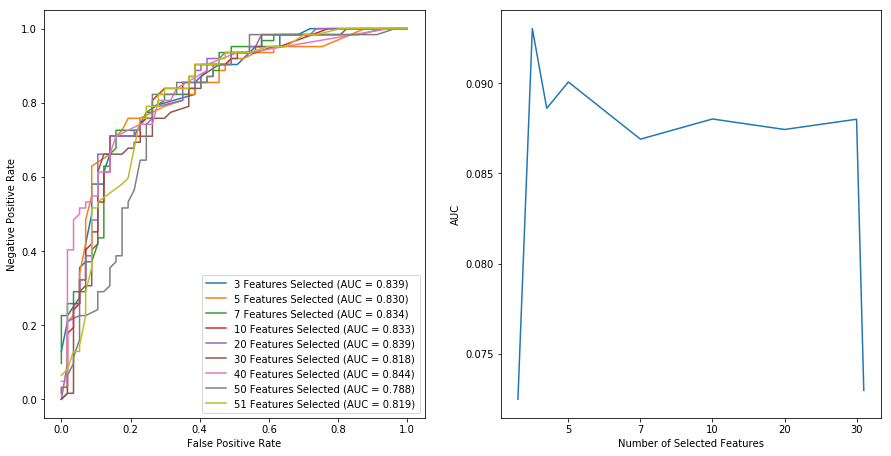

In [323]:
N = [3, 5, 7, 10, 20, 30, 40, 50, len(train_ds_scaled.columns)]
AUCvsFN (train_data_ds, 2**(-5), 2**(-3), 10, N, 100)

$\text{Check if the important features carry redundant information, i.e. highly correlated.}$

In [191]:
# Plot the covariance matrix for the n most important features.
def CovMatFea(dataset, min_split, min_leaf, n):
        
    X_Train = dataset.drop(['Y'], axis = 1)
    Y_Train = dataset['Y']
        
    # Scale the features based on the training set splitted out
    scaler = preprocessing.StandardScaler().fit(X_Train) # Scale based on training to prevent data leakage to validation set
    X_Train_scaled = pd.DataFrame(data = scaler.transform(X_Train), columns = X_Train.columns, index = X_Train.index)
    
    # Find the feature importance
    rf = RandomForestClassifier(min_samples_split = min_split, min_samples_leaf = min_leaf)
    rf.fit(X_Train_scaled, Y_Train)
    
    feature_mi_rf = rf.feature_importances_
    feature_mi_rf_dict = dict(zip(X_Train.columns, feature_mi_rf))
    mi_rf = pd.DataFrame(data = list(feature_mi_rf_dict.items()), columns = ['Feature', 'Importance'])
    mi_rf_sorted = mi_rf.sort_values(by = ['Importance'], ascending = False)
        
    # Plot the covariance matrix of top n features:
    hmap, ax = plt.subplots()
    hmap.set_size_inches(15, 15*0.618)
    hmap = sns.heatmap(X_Train_scaled.loc[:,mi_rf_sorted['Feature'][0 : n]].corr(), annot = True, ax = ax)
    plt.title('Feature Correlation Matrix')
    plt.show()


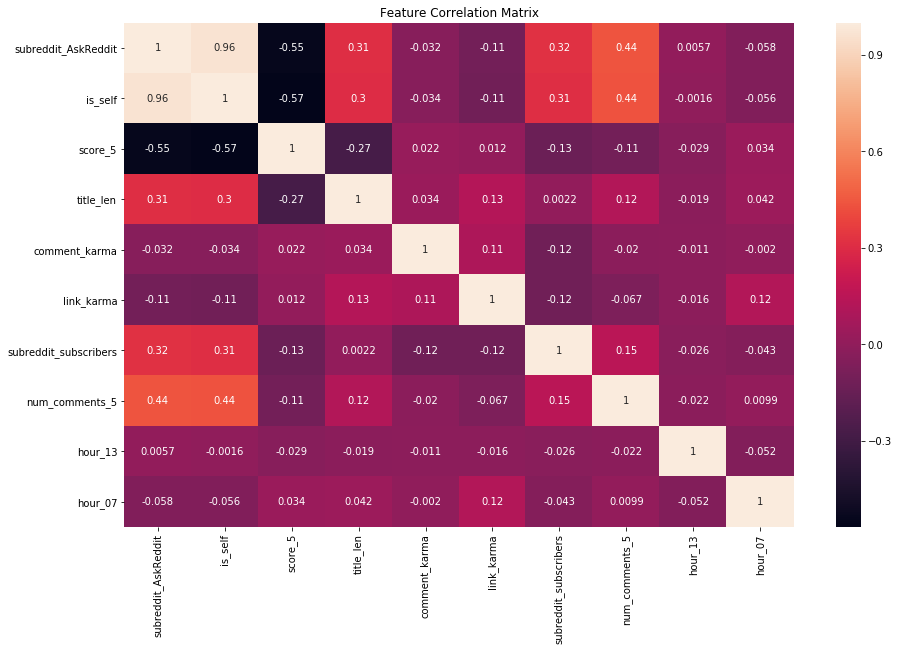

In [318]:
CovMatFea(train_ds_scaled, 2**(-5), 2**(-3), 10)

Text(0,0.5,'AUC')

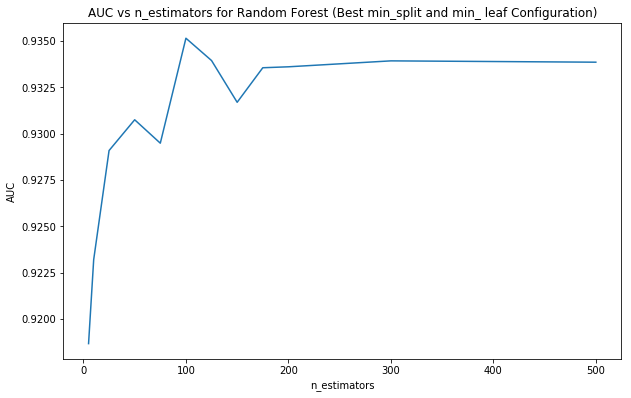

In [296]:
# Plot AUC vs n_estimators on the best split & leaf
plt.figure(figsize = (10, 10*0.618))
ne_candidate = [5, 10, 25, 50, 75, 100, 125, 150, 175, 200, 300, 500]
auc_ne = np.zeros(len(ne_candidate))
for ne in ne_candidate:
    rf_ne = RandomForestClassifier(n_estimators = ne, min_samples_split = 10**(-14), min_samples_leaf = 10**(-3))
    rf_ne.fit(X_train_ds_scaled, Y_train_ds)
    preds_rf_ne = rf_ne.predict_proba(X_test_scaled)[:, 1]
    fpr_rf_ne, tpr_rf_ne, thresholds_rf_ne = roc_curve(Y_test, preds_rf_ne)
    roc_auc_rf_ne = auc(fpr_rf_ne, tpr_rf_ne)
    auc_ne[ne_candidate.index(ne)] = roc_auc_rf_ne
    
plt.plot(ne_candidate, auc_ne)
plt.title('AUC vs n_estimators for Random Forest (Best min_split and min_ leaf Configuration)')
plt.xlabel('n_estimators')
plt.ylabel('AUC')
    

Text(0.5,0,'False Positive Rate')

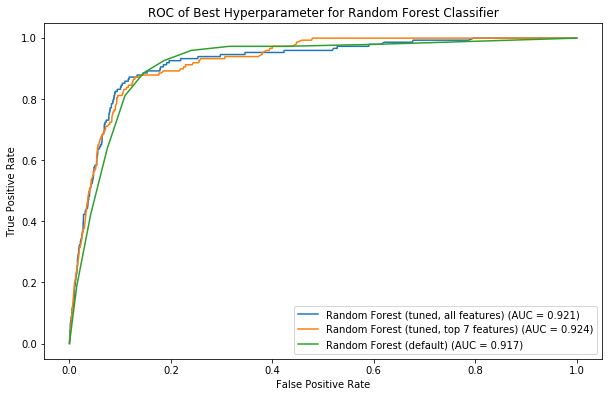

In [321]:
# Run on the best hyper-parameters
rf_best = RandomForestClassifier(min_samples_split = 10**(-5), min_samples_leaf = 10**(-3))
rf_best.fit(X_train_ds_scaled, Y_train_ds)
preds_rf_best_all = rf_best.predict_proba(X_test_scaled)[:, 1]
fpr_rf_best_all, tpr_rf_best_all, thresholds_rf_best_all = roc_curve(Y_test, preds_rf_best_all)
roc_auc_rf_best_all = auc(fpr_rf_best_all, tpr_rf_best_all)

fn = 7
feature_mi_rf = rf_best.feature_importances_
feature_mi_rf_dict = dict(zip(X_train_ds_scaled.columns, feature_mi_rf))
mi_rf = pd.DataFrame(data = list(feature_mi_rf_dict.items()), columns = ['Feature', 'Importance'])
mi_rf_sorted = mi_rf.sort_values(by = ['Importance'], ascending = False)
feature_7 = mi_rf_sorted['Feature'][0 : fn]
X_train_7, X_test_7 = X_train_ds_scaled.filter(items = feature_7), X_test_ds_scaled.filter(items = feature_7)
rf_best.fit(X_train_7, Y_train_ds)
preds_rf_best_7 = rf_best.predict_proba(X_test_7)[:, 1]
fpr_rf_best_7, tpr_rf_best_7, thresholds_rf_best_7 = roc_curve(Y_test, preds_rf_best_7)
roc_auc_rf_best_7 = auc(fpr_rf_best_7, tpr_rf_best_7)




plt.figure(figsize = (10, 10*0.618))
plt.title('ROC of Best Hyperparameter for Random Forest Classifier')
plt.plot(fpr_rf_best_all, tpr_rf_best_all, label = 'Random Forest (tuned, all features)' + ' (AUC = %0.3f)' % roc_auc_rf_best_all)
plt.plot(fpr_rf_best_7, tpr_rf_best_7, label = 'Random Forest (tuned, top {} features)'.format(fn) + ' (AUC = %0.3f)' % roc_auc_rf_best_7)
plt.plot(fpr_rf_baseline_ds, tpr_rf_baseline_ds, label = 'Random Forest (default)' + ' (AUC = %0.3f)' % roc_auc_rf_baseline_ds)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

##Finally, compare all the models!
Model List: <br>
LogReg(baseline)
LogReg(downsampled baseline)<br>
LogReg(C = 0.1, downsampled & stratified, LASSO)<br>
LogReg(C = 0.1, downsampled & stratified, Ridge)<br>
<br>
RF(baseline)
RF(downsampled baseline)<br>
RF(downsampled, min_split = 10^(-13.25), min_leaf = 10^(-8), feaure number = ALL)<br>
RF(downsampled, min_split = 10^(-13.25), min_leaf = 10^(-8), feaure number = 7)<br>


In [324]:
result_table = pd.DataFrame(columns = ['AUC'], 
                           index = ['Logistic Regression (baseline)',
                                    'Logistic Regression(downsampled, default hyperparameteres)',
                                   'Logistic Regression (downsampled, C = 0.1, penalty = L1)',
                                   'Logistic Regression (downsampled, C = 0.1, penalty = L2)',
                                   'Random Forest (baseline)',
                                   'Random Forest (downsampled, default hyperparameters)',
                                   'Random Forest (downsampled, Log10(min_samples_split) = -14, Log10(min_samples_leaf) = -3, ALL features)',
                                   'Random Forest (downsampled, Log10(min_samples_split) = -14, Log10(min_samples_leaf) = -3, top 7 features)'])

result_table.loc['Logistic Regression (baseline)']  = np.round(roc_auc_lr_baby, 3)
result_table.loc['Random Forest (baseline)']  = np.round(roc_auc_rf_baby, 3)
result_table.loc['Logistic Regression(downsampled, default hyperparameteres)']  = np.around(roc_auc_lr_baseline_ds, 3)
result_table.loc['Random Forest (downsampled, default hyperparameters)']  = np.around(roc_auc_rf_baseline_ds, 3)
result_table.loc['Logistic Regression (downsampled, C = 0.1, penalty = L1)'] = np.around(roc_auc_lr_best_l1, 3)
result_table.loc['Logistic Regression (downsampled, C = 0.1, penalty = L2)'] = np.around(roc_auc_lr_best_l2, 3)
result_table.loc['Random Forest (downsampled, Log10(min_samples_split) = -14, Log10(min_samples_leaf) = -3, ALL features)'] = np.around(roc_auc_rf_best_all, 3)
result_table.loc['Random Forest (downsampled, Log10(min_samples_split) = -14, Log10(min_samples_leaf) = -3, top 7 features)'] = np.around(roc_auc_rf_best_7, 3)


result_table



,AUC
Logistic Regression (baseline),0.872
"Logistic Regression(downsampled, default hyperparameteres)",0.929
"Logistic Regression (downsampled, C = 0.1, penalty = L1)",0.935
"Logistic Regression (downsampled, C = 0.1, penalty = L2)",0.93
Random Forest (baseline),0.715
"Random Forest (downsampled, default hyperparameters)",0.917
"Random Forest (downsampled, Log10(min_samples_split) = -14, Log10(min_samples_leaf) = -3, ALL features)",0.921
"Random Forest (downsampled, Log10(min_samples_split) = -14, Log10(min_samples_leaf) = -3, top 7 features)",0.924


# NLP Stacking

In [246]:
# NLP Stacking
# Isolate the fields of the training and testing sets for NLP task
X_train_ds_nlp = pd.DataFrame(data = data_raw['title'].iloc[X_train_ds.index], columns = ['title'])

X_test_nlp = pd.DataFrame(data = data_raw['title'].iloc[X_test_ds.index], columns = ['title'])


In [279]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics

#instantiate TfidVectorizer
vectorizerTfidf = TfidfVectorizer(stop_words='english', binary = True, ngram_range = (1, 1), norm = 'l1', analyzer = 'char')
#fit vectorizerTfidf to and transform the training data
X_train_matrix_tfidf = vectorizerTfidf.fit_transform(X_train_ds_nlp['title'].values.astype('U'))
#transform the test and training data
X_test_matrix_tfidf = vectorizerTfidf.transform(X_test_nlp['title'].values.astype('U'))

#Bernoulli Naive Bayes model for the TfidfVectorizer
BernVectTfidf = BernoulliNB().fit(X_train_matrix_tfidf, Y_train_ds)


In [280]:
from scipy.sparse import vstack
# TODO:  Add P(Y = 1|Embedding = BernoulliVectTfidf) as a feature in the original dataset
#X_titles_ds = pd.concat([X_train_ds_nlp, X_test_nlp], axis = 0)
Y = pd.concat([Y_train_ds, Y_test], axis = 0)


#fit vectorizerTfidf to and transform the training data
matrix_tfidf = vstack([X_train_matrix_tfidf, X_test_matrix_tfidf])

#BernVectTfidf_stack = BernoulliNB().fit(matrix_tfidf, Y_titles)

BernVectTfidfPreds_stack = BernVectTfidf.predict_proba(matrix_tfidf)[:, 0]

cut_idx = len(X_train_ds.index)
X_TRAIN_stack, X_TEST_stack = X_train_ds_scaled.copy(), X_test_scaled.copy()
X_TRAIN_stack['title_proba'], X_TEST_stack['title_proba'] = BernVectTfidfPreds_stack[0 : cut_idx], BernVectTfidfPreds_stack[cut_idx : len(Y.index)]

/Users/elle0804/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


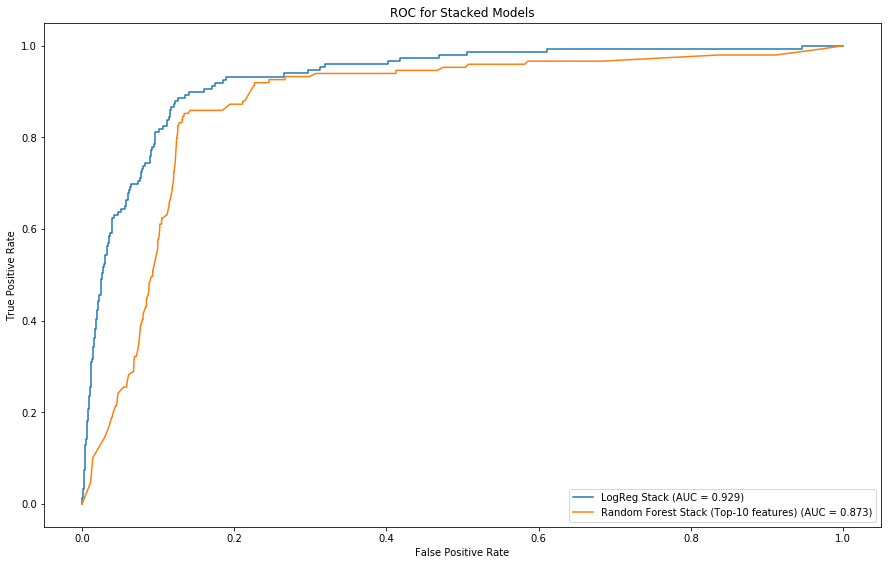

In [325]:
# TODO: stack LogReg onto the new dataset
lr_stack = LogisticRegression(C = 0.1, penalty = 'l1')
lr_stack.fit(X_TRAIN_stack, Y_train_ds)

preds_lr_stack = lr_stack.predict_proba(X_TEST_stack)[:, 1]

fpr_lr_stack, tpr_lr_stack, thresholds_lr_stack = roc_curve(Y_test, preds_lr_stack)
roc_auc_lr_stack = auc(fpr_lr_stack, tpr_lr_stack)


# TODO: stack RF onto the new dataset
rf_stack = RandomForestClassifier(min_samples_split = 2**(-14), min_samples_leaf = 2**(-3))
feature_chosen = ['score_5', 'is_self', 'subreddit_AskReddit', 'subreddit_gaming', 'subreddit_aww', 'subreddit_subscribers',
                 'link_karma', 'comment_karma', 'title_len', 'num_comments_5', 'title_proba']
#rf_stack.fit(X_TRAIN_stack.loc[:, feature_chosen], Y_train_ds)
rf_stack.fit(X_TRAIN_stack, Y_train_ds)

#preds_rf_stack = rf_stack.predict_proba(X_TEST_stack.loc[:, feature_chosen])[:, 1]
preds_rf_stack = rf_stack.predict_proba(X_TEST_stack)[:, 1]

fpr_rf_stack, tpr_rf_stack, thresholds_rf_stack = roc_curve(Y_test, preds_rf_stack)
roc_auc_rf_stack = auc(fpr_rf_stack, tpr_rf_stack)


fig = plt.figure(figsize = (15, 15*0.618))
plt.plot(fpr_lr_stack, tpr_lr_stack, label = 'LogReg Stack (AUC = %0.3f)' % roc_auc_lr_stack)
#plt.plot(fpr_lr_stack, tpr_lr_stack, label = 'LogReg Stack (AUC = %0.3f)' % roc_auc_lr_stack)
plt.plot(fpr_rf_stack, tpr_rf_stack, label = 'Random Forest Stack (Top-10 features) (AUC = %0.3f)' % roc_auc_rf_stack)
plt.legend(loc = 'lower right')

plt.title('ROC for Stacked Models')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
fig.show()